# Setup

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

# Data Preprocessing

## Load Data

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL_Project/task_1/train.csv', sep = ',')
test_df  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL_Project/task_1/test.csv', sep = ',')

In [6]:
train_col = train_df['y']
test_col  = train_df['y']

## Split the data

In [7]:
n = len(train_df)

train_data = train_col[0          : int(n*0.8)].to_numpy()
valid_data = train_col[int(n*0.8) :           ].to_numpy()

test_data  = test_col.to_numpy()

In [8]:
train_data.shape, valid_data.shape, test_data.shape

((115928,), (28983,), (144911,))

## Min Max scale

In [9]:
scaler = MinMaxScaler(feature_range=(-1,1))

sv = scaler.fit_transform(train_data.reshape(-1, 1))
sv = np.reshape(sv, len(sv))
train = sv

sv = scaler.transform(valid_data.reshape(-1, 1))
sv = np.reshape(sv, len(sv))
valid = sv

sv = scaler.transform(test_data.reshape(-1, 1))
sv = np.reshape(sv, len(sv))
test = sv

In [10]:
train.shape, valid.shape, test.shape

((115928,), (28983,), (144911,))

In [11]:
train = train.reshape((train.shape[0], 1))
valid = valid.reshape((valid.shape[0], 1))
test  = test.reshape((test.shape[0]  , 1))

In [12]:
train.shape, valid.shape, test.shape

((115928, 1), (28983, 1), (144911, 1))

# Data windowing

In [13]:
def split(data, win_size=30, win_shift=6, offset=1):

  rows = np.arange(win_size, len(data) - win_shift - 1, win_shift)

  samples = np.zeros((len(rows), win_size, data.shape[-1]))
  targets = np.zeros((len(rows),))

  for j, row in enumerate(rows):
    samples[j] = data[j * win_shift: row]
    targets[j] = data[row: row + offset]

  return samples, targets

# Window 5 min Shift 1 min

## Single Output Models

In [14]:
x_train, y_train = split(train)
x_valid, y_valid = split(valid)
x_test , y_test  = split(test)

In [15]:
x_train.shape, y_train.shape

((19316, 30, 1), (19316,))

In [16]:
x_valid.shape, y_valid.shape

((4825, 30, 1), (4825,))

In [17]:
x_test.shape, y_test.shape

((24146, 30, 1), (24146,))

In [18]:
seq_len  = x_train.shape[1]
num_feat = x_train.shape[2]

### Recurrent

In [19]:
lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(16, input_shape = (seq_len, num_feat), return_sequences=True),
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(1, activation='tanh')
])

lstm.compile(loss = 'mae', optimizer='adam')
history = lstm.fit(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid), verbose = 1, batch_size=32, shuffle=False)

Epoch 1/100
604/604 [==============================] - 21s 27ms/step - loss: 0.1387 - val_loss: 0.1099
Epoch 2/100
604/604 [==============================] - 15s 26ms/step - loss: 0.0930 - val_loss: 0.0815
Epoch 3/100
604/604 [==============================] - 15s 25ms/step - loss: 0.0808 - val_loss: 0.0781
Epoch 4/100
604/604 [==============================] - 16s 26ms/step - loss: 0.0738 - val_loss: 0.0644
Epoch 5/100
604/604 [==============================] - 16s 26ms/step - loss: 0.0696 - val_loss: 0.0614
Epoch 6/100
604/604 [==============================] - 16s 26ms/step - loss: 0.0656 - val_loss: 0.0696
Epoch 7/100
604/604 [==============================] - 15s 25ms/step - loss: 0.0626 - val_loss: 0.0667
Epoch 8/100
604/604 [==============================] - 16s 26ms/step - loss: 0.0613 - val_loss: 0.0657
Epoch 9/100
604/604 [==============================] - 15s 25ms/step - loss: 0.0598 - val_loss: 0.0653
Epoch 10/100
604/604 [==============================] - 15s 25ms/step - l

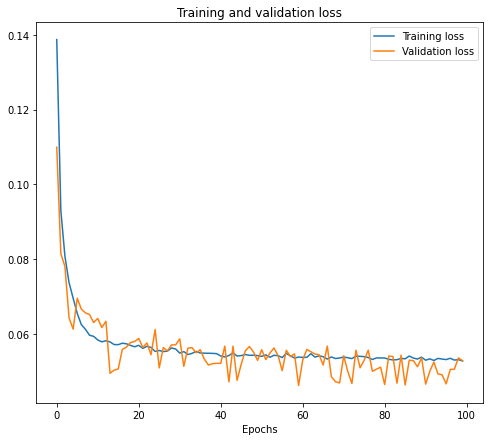

In [20]:
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(len(loss)) 

plt.figure(figsize=(8,7))
plt.plot(epochs, loss,  label='Training loss') 
plt.plot(epochs, val_loss,  label='Validation loss') 
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## Testing

In [21]:
prediction_lstm = lstm.predict(x_test)

In [22]:
type(prediction_lstm)

numpy.ndarray

In [23]:
prediction_lstm.shape, y_test.shape

((24146, 1), (24146,))

**Revert scaling**

In [24]:
y_test = y_test.reshape((y_test.shape[0], 1))
y_test.shape

(24146, 1)

In [25]:
y_test          = scaler.inverse_transform(y_test)
prediction_lstm = scaler.inverse_transform(prediction_lstm)

In [26]:
prediction_lstm.shape, y_test.shape

((24146, 1), (24146, 1))

**Calculate the Mean Absolute Error**

In [27]:
y_test          = y_test.reshape((y_test.shape[0]))
prediction_lstm = prediction_lstm.reshape((prediction_lstm.shape[0]))

In [28]:
prediction_lstm.shape, y_test.shape

((24146,), (24146,))

In [29]:
mae_lstm = mean_absolute_error(prediction_lstm, y_test)

print(f"Mean Absolute Error Recurrent Network: {mae_lstm}")

Mean Absolute Error Recurrent Network: 59.22018335695501
